In [46]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [47]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression

from rdkit import Chem
from rdkit.Chem import AllChem

In [48]:
from sklearn.svm import SVC

from sklearn.svm import SVR

In [49]:
from tdc.single_pred.adme import ADME
from tdc import Evaluator

#tdc.single_pred.adme i tdc.Evaluator to moduły biblioteki TDC (Therapeutics Data Commons),
#która umożliwia modelowanie predykcyjne właściwości leków.

In [50]:
#definiujemy klasy służące do ekstracji cech z danych 

class Featurizer: #Definiuje interfejs dla obiektów, które generują cechy z danych.
    
    def __init__(self, y_column, smiles_col='Drug', **kwargs): #y_column- nazwa kolumny z y, a smiles_col- nazwa kolumny ze SMILES
                                                               # **kwargs- przechowywanie innych argumentów przekazywanych do metody
        self.y_column = y_column           
        self.smiles_col = smiles_col       #Dzięki self można odwołać się do atrybutów i metod tej konkretnej instancji wewnątrz klasy.
        self.__dict__.update(kwargs)
    
    
    def __call__(self, df):                #W tym przypadku metoda __call__ nie jest zdefiniowana, co oznacza, 
        raise NotImplementedError()        #że każda klasa dziedzicząca po Featurizer musi ją zaimplementować, aby można było ją wywołać. 


class CheatingFeaturizer(Featurizer):      #dziedziczy po klasie Featurizer
    
    
    def __call__(self, df):                # W metodzie __call__() tej klasy, dla każdego wiersza w danych wejściowych df, 
        
        predictions = []                   
        labels = []
        predictions_column_name = 'Y'
        
        for i, row in df.iterrows():
            predictions.append(row[predictions_column_name])      # Wartość predykcji pobierana jest z kolumny 'Y',
            labels.append(row[self.y_column])                     # Wartość etykiety z kolumny zdefiniowanej w klasie bazowej y_column.
            
        predictions = np.array(predictions)       #wartości etykiet i predykcji są zwracane w postaci tablic numpy
        labels = np.array(labels)
        return predictions, labels
        
        

class ECFPFeaturizer(Featurizer):               #też dziedziczy po Featurizer
    
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        
        self.radius = radius                    #ustawiamy wartości pól radius i length w obiekcie ECFPFeaturizer na wartości podane przy tworzeniu obiektu.
        self.length = length
        super().__init__(y_column, **kwargs)    #wywołanie konstruktora klasy nadrzędnej Featurizer 
        
        #Dzięki temu, do pola y_column w obiekcie ECFPFeaturizer zostaje przypisana wartość argumentu y_column 
        #podanego przy tworzeniu obiektu, a wszystkie dodatkowe argumenty kwargs zostaną zapisane w formie słownikowej pod atrybutami obiektu ECFPFeaturizer.
        
        
        
    def __call__(self, df):  #W tej metodzie obliczane są fingerprinty dla cząsteczek na podstawie SMILES-ów, 
                             #które znajdują się w kolumnie określonej przez argument smiles_col
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length) #Fingerprinty obliczane są z użyciem funkcji GetMorganFingerprintAsBitVect z modułu AllChem biblioteki RDKit, która tworzy reprezentację molekularną cząsteczki.
            fingerprints.append(fp)
            labels.append(y)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels



In [51]:
from sklearn.ensemble import RandomForestRegressor

def train(X_train, y_train, X_valid, y_valid):
    # create and train your model 
    model = RandomForestRegressor(verbose=1)
    model.fit(X_train, y_train)
    return model

In [62]:
#verbose w RandomForestRegressor określa, czy algorytm ma wypisywać informacje diagnostyczne na temat procesu trenowania modelu, takie jak postęp uczenia, czas trwania poszczególnych etapów, itp. 
#Domyślnie ustawiony jest na wartość 0, co oznacza brak informacji diagnostycznych. 
#Zwiększenie wartości verbose zwiększa liczbę informacji wypisywanych podczas uczenia modelu.

In [52]:
def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred

In [53]:
data = ADME('Solubility_AqSolDB')
split = data.get_split()

Found local copy...
Loading...
Done!


In [56]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

In [57]:
featurizer = ECFPFeaturizer(y_column='Y')
scores = []

In [58]:
X_train, y_train = featurizer(split['train'])
X_valid, y_valid = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])
model = train(X_train, y_train, X_valid, y_valid)
predictions = predict(model, X_test, y_test)  # y_test won't be available during evaluation!
rmse_score = rmse(y_test, predictions)
mae_score = mae(y_test, predictions)
r2_score = r_squared(y_test, predictions)
print(f'RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')

[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not removing hydrogen atom without neighbors
[22:46:34] WARNING: not r

RMSE, MAE, R2 = 1.3466151557677688, 0.9809679049120424, 0.6658418186819713


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


The most soluble compounds in the dataset:


[22:48:38] WARNING: not removing hydrogen atom without neighbors
[22:48:38] WARNING: not removing hydrogen atom without neighbors


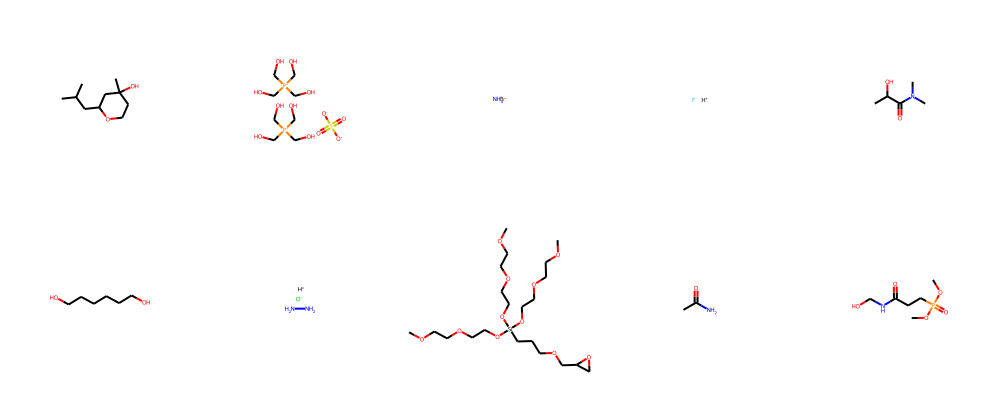

The least soluble compounds in the dataset:


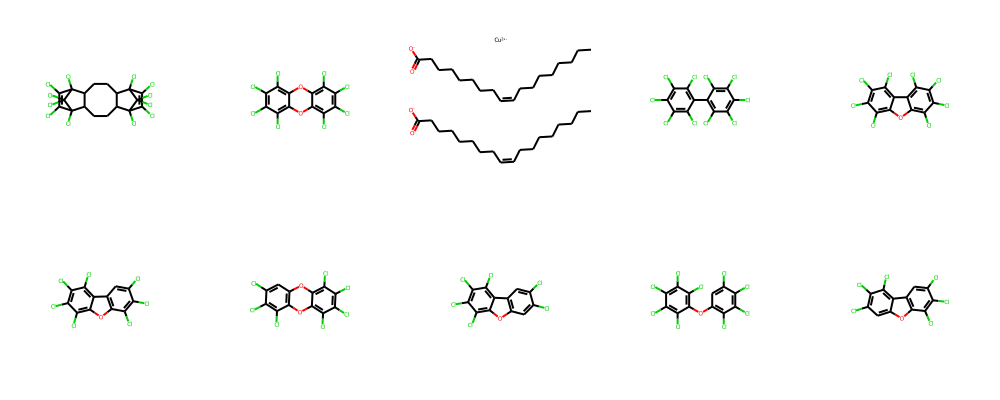

In [59]:
print('The most soluble compounds in the dataset:')
smiles_list = split['train'].sort_values('Y', ascending=False).iloc[:10].Drug
display(Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in smiles_list], molsPerRow=5))
print('The least soluble compounds in the dataset:')
smiles_list = split['train'].sort_values('Y', ascending=True).iloc[:10].Drug
display(Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in smiles_list], molsPerRow=5))

In [67]:
from tdc.single_pred.adme import ADME
from tdc import Evaluator

class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()


class CheatingFeaturizer(Featurizer):
    def __call__(self, df):
        predictions = []
        labels = []
        predictions_column_name = 'Y'
        for i, row in df.iterrows():
            predictions.append(row[predictions_column_name])
            labels.append(row[self.y_column])
        predictions = np.array(predictions)
        labels = np.array(labels)
        return predictions, labels
        

class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels

In [71]:
from sklearn.ensemble import RandomForestClassifier

def train(X_train, y_train, X_valid, y_valid):
    # TODO: create and train your model 
    model = RandomForestClassifier(verbose=1)
    model.fit(X_train, y_train)
    return model


def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


In [72]:
data = ADME('bbb_martins')
split = data.get_split(method='scaffold')

# TODO: write a new featurizer and replace the one below
featurizer = ECFPFeaturizer(y_column='Y')
scores = []

Found local copy...
Loading...
Done!
100%|█████████████████████████████████████| 2030/2030 [00:01<00:00, 1330.48it/s]


In [75]:
roc_auc = Evaluator(name = 'ROC AUC')
accuracy = Evaluator(name = 'Accuracy')

X_train, y_train = featurizer(split['train'])
X_valid, y_valid = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])
model = train(X_train, y_train, X_valid, y_valid)
predictions = predict(model, X_test, y_test)  # y_test won't be available during evaluation!

print(predictions[:10])
roc_auc_score = roc_auc(y_test, predictions)
accuracy_score = accuracy(y_test, predictions)
r2_score = r_squared(y_test, predictions)
print(f'ROC AUC, accuracy = {roc_auc_score}, {accuracy_score}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1 1 1 0 0 0 0 0 1 1]
ROC AUC, accuracy = 0.7185741088180113, 0.8768472906403941


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
